In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Dataset plotting

For grid of shape ((100, 87), (100, 87)), dx=772, dy=771
For grid of shape ((229, 200), (229, 200)), dx=500, dy=500
For grid of shape ((169, 150), (169, 150)), dx=1e+03, dy=1e+03


Text(0.5, 0.98, 'Illinois, Cook')

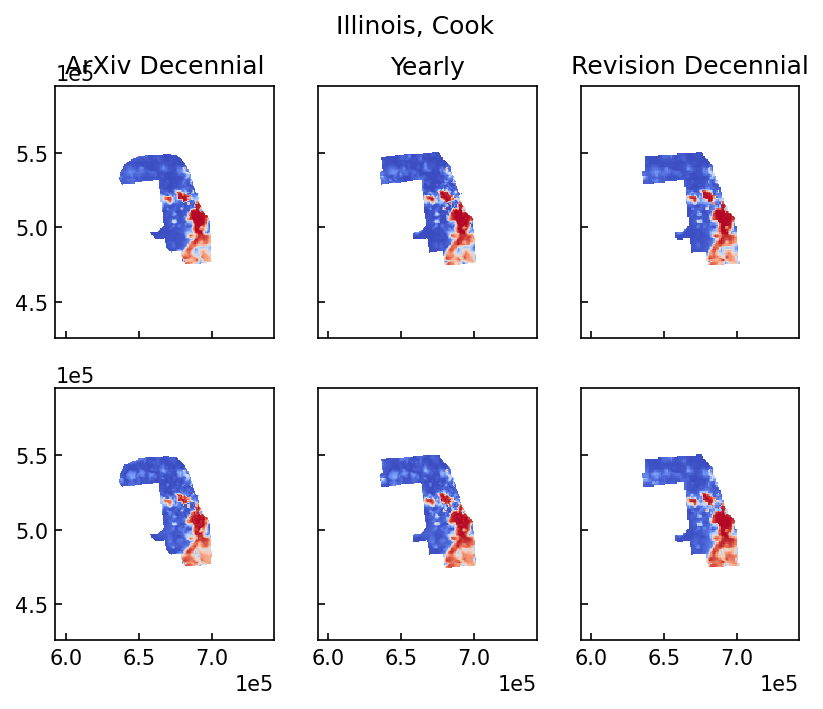

In [6]:
import os
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import scipy.interpolate as interpolate
import h5py
import matplotlib.pyplot as plt

data_dir = '/home/jcolen/data/sociohydro/decennial/revision/'

fig, ax = plt.subplots(2, 3, dpi=150, sharex=True, sharey=True)

state = 'Illinois'
county = 'Cook'

with h5py.File(f'/home/jcolen/data/sociohydro/decennial/processed/cook_IL.hdf5', 'r') as h5f:
    dx = h5f['x_grid'][1,1] - h5f['x_grid'][0,0]
    dy = h5f['y_grid'][1,1] - h5f['y_grid'][0,0]
    print(f'For grid of shape {h5f["x_grid"].shape, h5f["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
    for i in range(2):
        ax[i,0].pcolormesh(h5f['x_grid'], h5f['y_grid'],
                           (h5f['w_grid_array_masked'][:,:,3+i] - h5f['b_grid_array_masked'][:,:,3+i]) / 
                           (h5f['w_grid_array_masked'][:,:,3+i] + h5f['b_grid_array_masked'][:,:,3+i]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)        
with h5py.File(f'/home/jcolen/data/sociohydro/yearly/processed/{state}_{county}.hdf5', 'r') as h5f:
    for i, year in enumerate(['2010', '2020']):
        g = h5f[year]
        if i == 0:
            dx = g['x_grid'][1,1] - g['x_grid'][0,0]
            dy = g['y_grid'][1,1] - g['y_grid'][0,0]
            print(f'For grid of shape {g["x_grid"].shape, g["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
        ax[i,1].pcolormesh(g['x_grid'], g['y_grid'], 
                           (g['w_grid_masked'][:] - g['b_grid_masked'][:]) / 
                           (g['w_grid_masked'][:] + g['b_grid_masked'][:]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)

with h5py.File(f'/home/jcolen/data/sociohydro/decennial/revision/gridded/{state}_{county}.hdf5', 'r') as h5f:
    for i, year in enumerate(['2010', '2020']):
        g = h5f[year]
        if i == 0:
            dx = g['x_grid'][1,1] - g['x_grid'][0,0]
            dy = g['y_grid'][1,1] - g['y_grid'][0,0]
            print(f'For grid of shape {g["x_grid"].shape, g["y_grid"].shape}, dx={dx:.3g}, dy={dy:.3g}')
        ax[i,2].pcolormesh(g['x_grid'], g['y_grid'], 
                           (g['white_grid_county'][:] - g['black_grid_county'][:]) / 
                           (g['white_grid_county'][:] + g['black_grid_county'][:]),
                           vmin=-1, vmax=1, cmap='coolwarm_r', rasterized=True)
        
for a in ax.ravel():
    a.ticklabel_format(axis='both', style='sci', scilimits=(0,0))
    a.tick_params(which='both', direction='in')
ax[0,0].set_title('ArXiv Decennial')
ax[0,1].set_title('Yearly')
ax[0,2].set_title('Revision Decennial')
fig.suptitle(f"{state}, {county}")

Text(0, 0.33, '2020 Census')

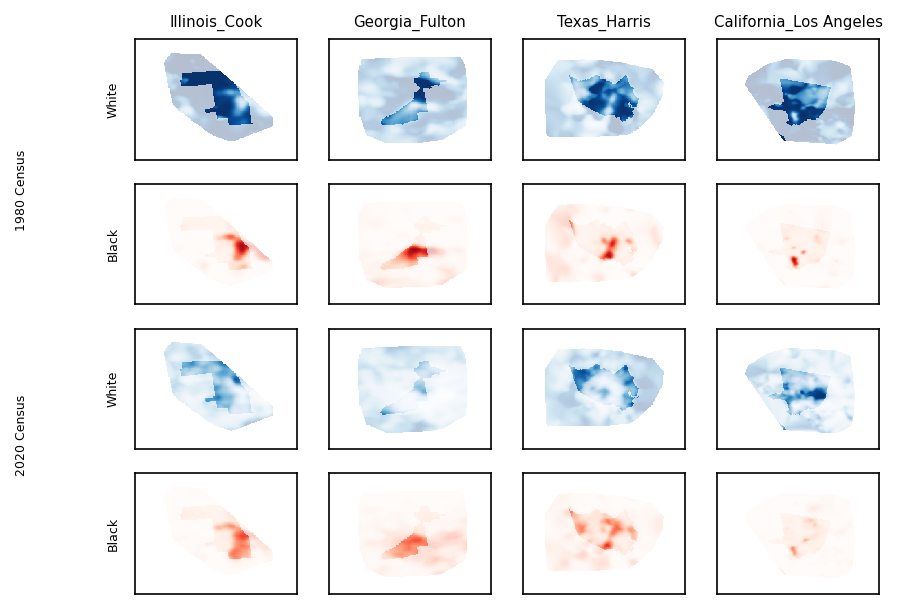

In [18]:
from census_dataset import CensusDataset
from torch.utils.data import ConcatDataset

plt.rcParams['font.size'] = 6

def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
        
dataset = ConcatDataset([
    CensusDataset('Illinois_Cook'),
    CensusDataset('Georgia_Fulton'),
    CensusDataset('Texas_Harris'),
    CensusDataset('California_Los Angeles'),
])
fig, ax = plt.subplots(4, 4, dpi=150, sharex='col', sharey='col')
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    wb = ds[0]['wb']
    alpha = np.ones(ds.mask.shape)
    alpha[~ds.mask] = 0.3
    ax[0,i].pcolormesh(ds.x, ds.y, wb[0,0], cmap='Blues', vmin=0, vmax=1, alpha=alpha)
    ax[1,i].pcolormesh(ds.x, ds.y, wb[0,1], cmap='Reds', vmin=0, vmax=1, alpha=alpha)
    ax[2,i].pcolormesh(ds.x, ds.y, wb[-1,0], cmap='Blues', vmin=0, vmax=1, alpha=alpha)
    ax[3,i].pcolormesh(ds.x, ds.y, wb[-1,1], cmap='Reds', vmin=0, vmax=1, alpha=alpha)
    ax[0,i].set_title(dataset.datasets[i].county)

for a in ax.flatten():
    a.set(xticks=[], yticks=[])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')
ax[2,0].set_ylabel(f'White')
ax[3,0].set_ylabel(f'Black')

fig.text(0, 0.67, '1980 Census', rotation=90, va='center', ha='left')
fig.text(0, 0.33, '2020 Census', rotation=90, va='center', ha='left')

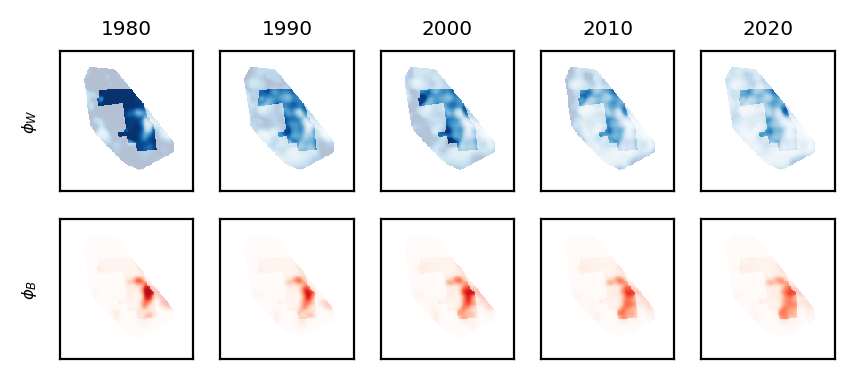

In [19]:
dataset = CensusDataset('Illinois_Cook')
dataset.validate()

fig, ax = plt.subplots(2, 5, figsize=(5, 2), dpi=200)

for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    ax[0,i].set_title(1980+i*10)
    alpha = np.ones(dataset.mask.shape)
    alpha[~dataset.mask] = 0.3
    ax[0,i].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues', alpha=alpha)
    ax[1,i].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds', alpha=alpha)

    
ax[0,0].set_ylabel('$\phi_W$')
ax[1,0].set_ylabel('$\phi_B$')

for a in ax.flatten():
    a.set(xticks=[], yticks=[])

# Neural network predictions

In [23]:
from census_dataset import CensusDataset
from scipy.interpolate import interp1d

def make_predictions_plot(model, county):
    dataset = CensusDataset(county).validate()
    wb1980 = dataset.wb(1980)
    wb2020 = dataset.wb(2020)

    # Neural network prediction
    batch = dataset[0]
    wb = batch['wb'].to(device)
    wb[wb.isnan()] = 0.
    with torch.no_grad():
        wbNN = model.simulate(wb[0:1], n_steps=40, dt=1)[0,-1].cpu().numpy()

    # Spline extrapolation
    spline = interp1d([1980, 1990], np.stack([dataset.wb(1980), dataset.wb(1990)]), axis=0, fill_value='extrapolate')
    wbSpline = spline(2020)

    # Error rates
    mse_NN = np.mean(np.power(wbNN - wb2020, 2).sum(0)[dataset.mask])
    mse_Sp = np.mean(np.power(wbSpline - wb2020, 2).sum(0)[dataset.mask])
    mse_No = np.mean(np.power(wb1980 - wb2020, 2).sum(0)[dataset.mask])

    print(f'For county = {county}')
    print(f'---------------------------------')
    print(f'\tModel\t\t|   MSE  ')
    print(f'---------------------------------')
    print(f'Neural Network\t\t|  {mse_NN:.3f}')
    print(f'Spline extrapolation\t|  {mse_Sp:.3f}')
    print(f'No dynamics\t\t|  {mse_No:.3f}')

    alpha = np.ones(dataset.mask.shape)
    alpha[~dataset.mask] = 0.

    def plot(column, dataset, wb):
        prop = (wb[0] - wb[1]) / wb.sum(0)
        pc0 = column[0].pcolormesh(dataset.x, dataset.y, prop, vmin=-1, vmax=1, cmap='bwr_r', alpha=alpha)
        pc1 = column[1].pcolormesh(dataset.x, dataset.y,  wb[0], vmin=0, vmax=1, cmap='Blues', alpha=alpha)
        pc2 = column[2].pcolormesh(dataset.x, dataset.y,  wb[1], vmin=0, vmax=1, cmap='Reds', alpha=alpha)
        return pc0, pc1, pc2

    fig, ax = plt.subplots(3, 4, dpi=200)

    plot(ax[:,0], dataset, wb1980)
    plot(ax[:,1], dataset, wb2020)
    plot(ax[:,2], dataset, wbNN)
    pc0, pc1, pc2 = plot(ax[:,3], dataset, wbSpline)

    plt.rcParams['font.size'] = 8
    plt.rcParams['axes.titlesize'] = 8

    fig.colorbar(pc0, ax=ax[0,:], ticks=[-1,1]).set_ticklabels(['All\nblack', 'All\nwhite'], 
        rotation=90, verticalalignment='center', multialignment='center')
    fig.colorbar(pc1, ax=ax[1,:], ticks=[0,1], label='Fraction')
    fig.colorbar(pc2, ax=ax[2,:], ticks=[0,1], label='Fraction')

    ax[0,0].set_title('1980\ncensus data')
    ax[0,1].set_title('2020\ncensus data')
    ax[0,2].set_title('2020\nNN prediction')
    ax[0,3].set_title('2020\nSpline extrapolation')

    ax[0,0].set_ylabel('Resident\nproportion')
    ax[1,0].set_ylabel('White\noccupation')
    ax[2,0].set_ylabel('Black\noccupation')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')

    return fig

In [46]:
import os
import glob
import json
import pandas as pd

def report_model(path):
    info = torch.load(path, map_location='cpu')
    with open(f'{path[:-5]}_args.txt', 'r') as f:
        params = json.load(f)
    ret = {
        'path': path,
        'val_loss': np.min(info['val_loss']),
        'train_loss': np.mean(info['train_loss'][-100:]),
        'epoch': np.argmin(info['val_loss']),
        'val_tmax': params.get('val_tmax', 10),
        'num_train_counties': params.get('num_train_counties', 30)
    }
    return ret

records = []
for path in glob.glob('models/*.ckpt'):
    records.append(report_model(path))

df = pd.DataFrame.from_records(records, np.arange(len(records)))
df.sort_values('val_loss')

,path,val_loss,train_loss,epoch,val_tmax,num_train_counties
0,models/CensusForecasting_gridded.ckpt,0.26023,0.001825,37,10,8


Reached minimium loss of 0.26 at epoch 37
For county = Georgia_Fulton
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.040
Spline extrapolation	|  0.619
No dynamics		|  0.243
For county = Illinois_Cook
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.020
Spline extrapolation	|  0.556
No dynamics		|  0.300
For county = Texas_Harris
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.129
Spline extrapolation	|  0.656
No dynamics		|  0.288
For county = California_Los Angeles
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.071
Spline extrapolation	|  1.591
No dynamics		|  0.242


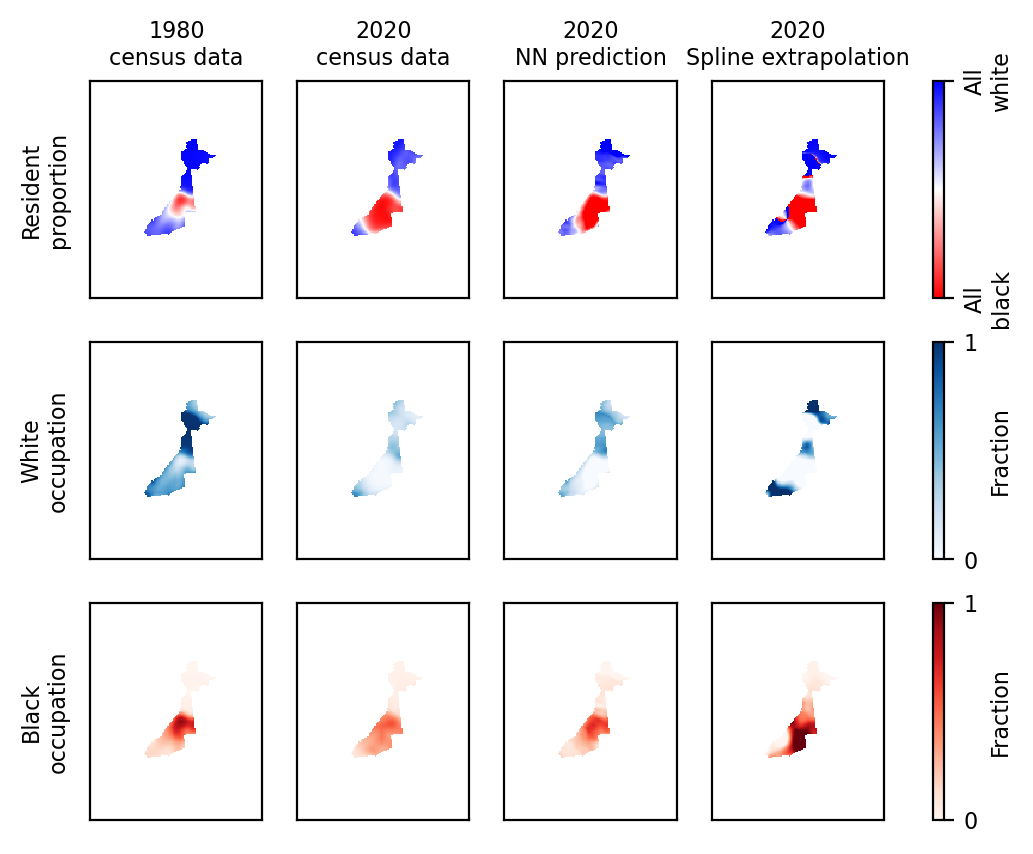

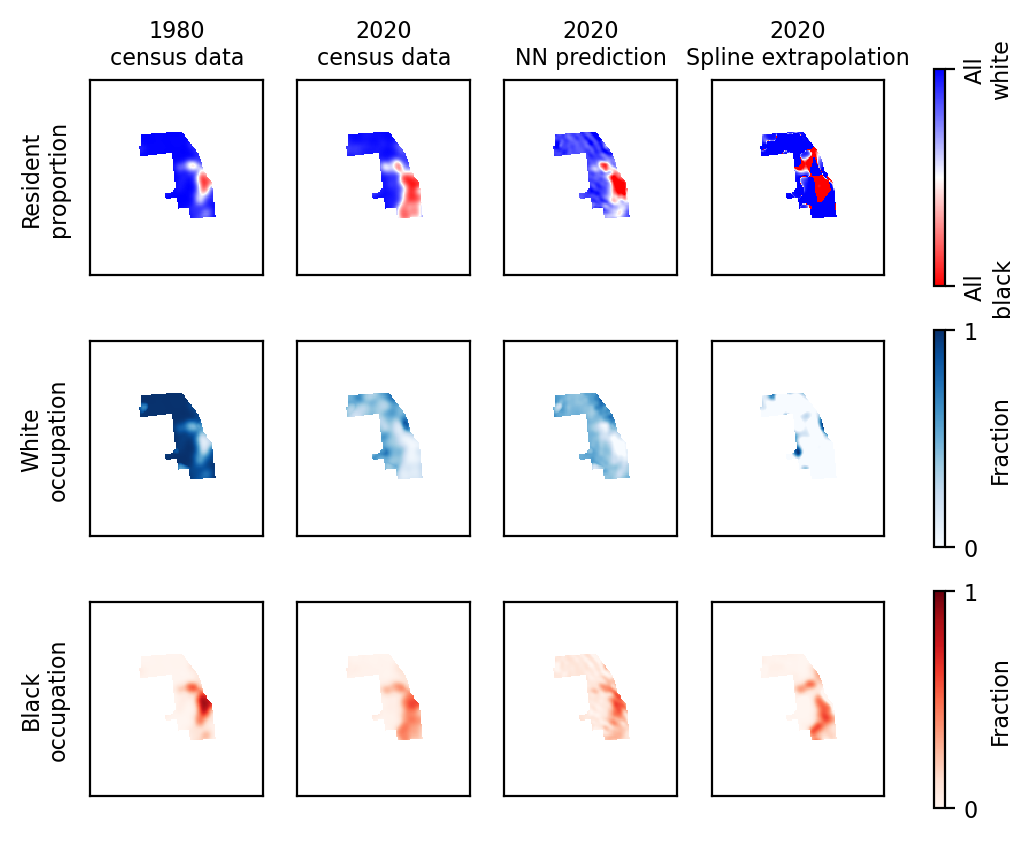

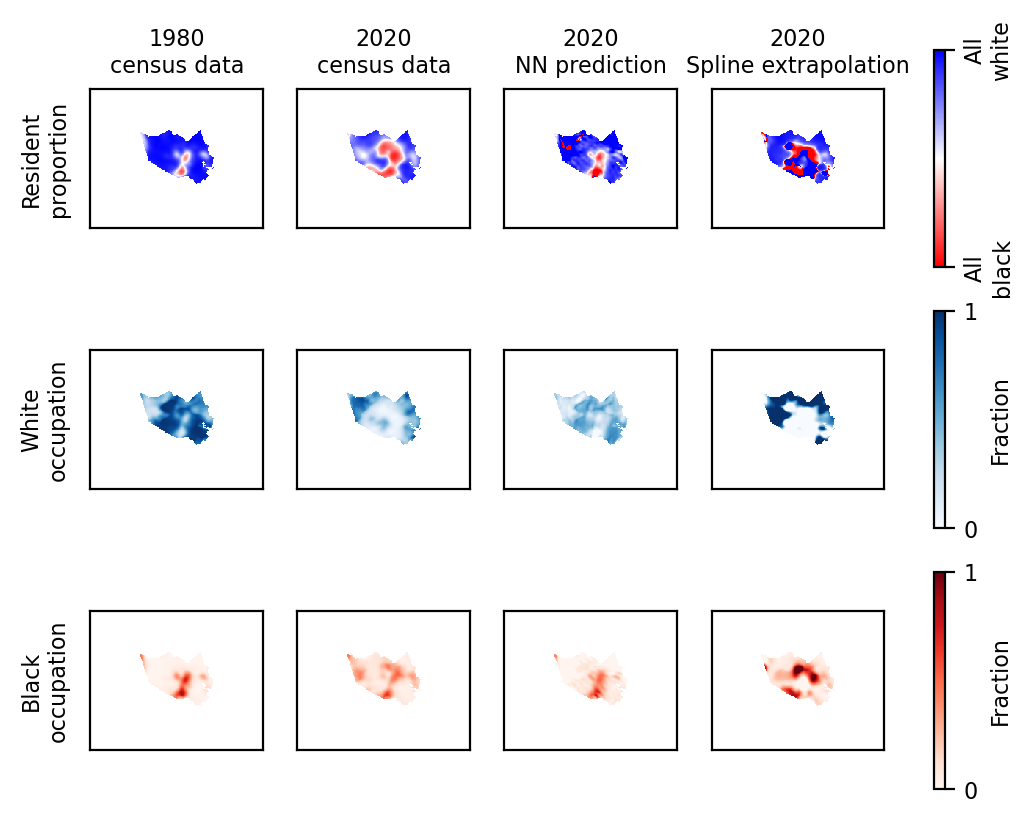

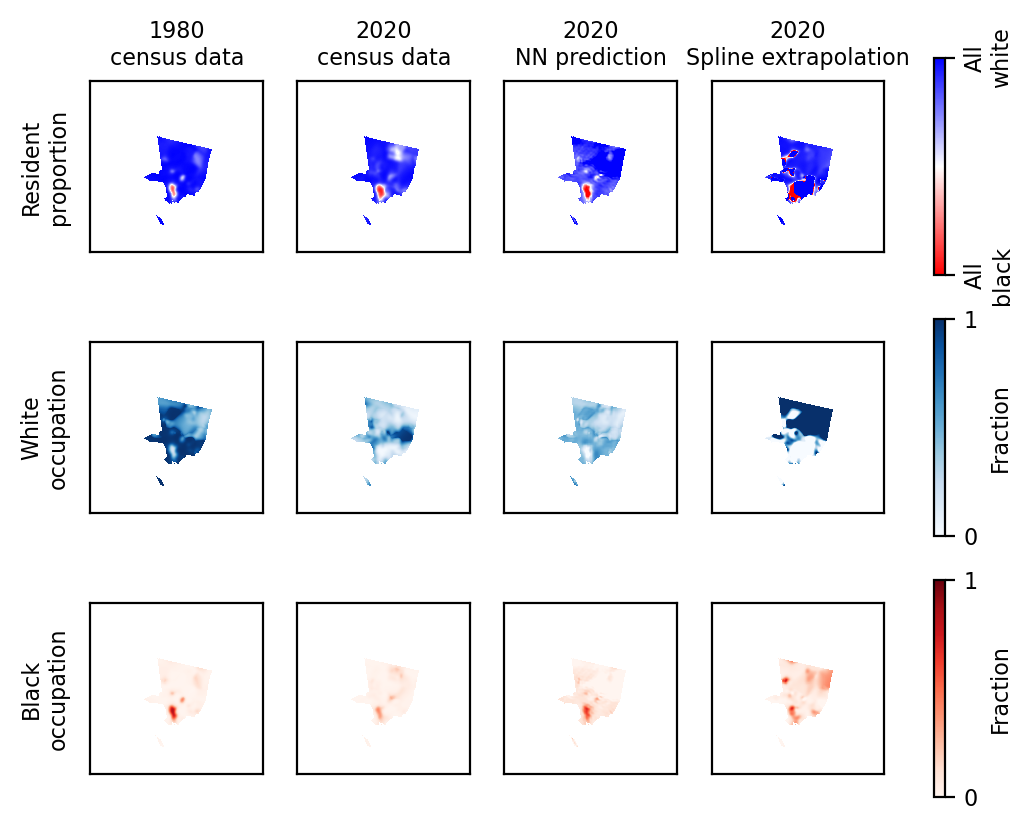

In [45]:
from census_nn import *

info = torch.load('models/CensusForecasting_gridded.ckpt')
print('Reached minimium loss of', np.round(np.min(info['val_loss']), 3), 'at epoch', np.argmin(info['val_loss']), flush=True)

model = CensusForecasting().to(device)
model.eval()
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'Georgia_Fulton');
make_predictions_plot(model, 'Illinois_Cook');
make_predictions_plot(model, 'Texas_Harris');
make_predictions_plot(model, 'California_Los Angeles');

# Saliency plotting

In [54]:
G_s, X_s, Y_s = [], [], []

with h5py.File(f'models/CensusForecasting_gridded_saliency.h5', 'r') as h5f:
    print(h5f.keys())
    for county in h5f.keys():
        print(county)
        cs = h5f[county]
        try:
            G_s.append(cs['G_S_sum'][()])
            X_s.append(cs['X'] - np.mean(cs['X']))
            Y_s.append(cs['Y'] - np.mean(cs['Y']))
        except:
            continue
            
        print(G_s[-1].shape, X_s[-1].shape, Y_s[-1].shape)

<KeysViewHDF5 ['California_Los Angeles', 'Georgia_Fulton', 'Illinois_Cook', 'Texas_Harris']>
California_Los Angeles
(2, 2, 339, 342) (339, 342) (339, 342)
Georgia_Fulton
(2, 2, 182, 144) (182, 144) (182, 144)
Illinois_Cook
(2, 2, 169, 150) (169, 150) (169, 150)
Texas_Harris
(2, 2, 190, 235) (190, 235) (190, 235)


170.50000000000045 169.00000000000003


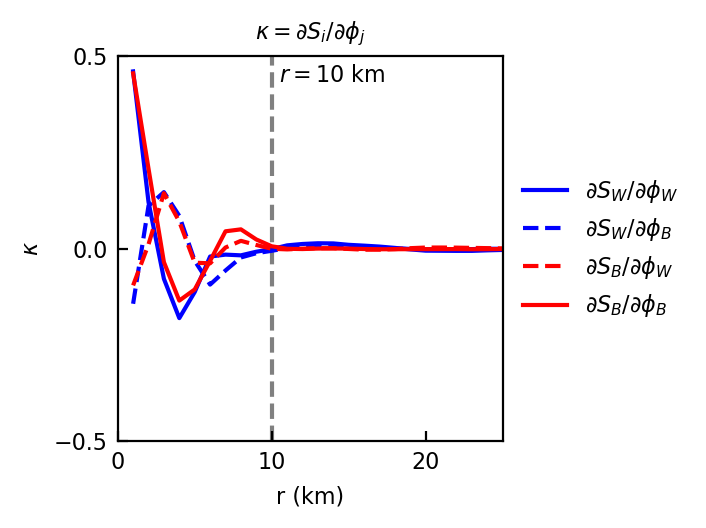

In [58]:
from scipy.interpolate import RectBivariateSpline

def get_Gr(G_s, idx, x, y):
    Gr = np.zeros([y.shape[0], x.shape[0]])
    for j in range(len(G_s)):
        Gsj = G_s[j][idx//2, idx%2]
        xj = X_s[j]
        yj = Y_s[j]
        Gr += RectBivariateSpline(xj[0,:], yj[:,0], Gsj.T)(x, y)
        
    Gr = Gr / (len(G_s)*40) #Take the mean
    Gr = Gr / np.abs(Gr).max() #Normalize by the maximum absolute value
    
    rgrid = np.linalg.norm(np.stack(np.meshgrid(x, y)), axis=0)
    r = np.arange(0, np.max(rgrid) / np.sqrt(2), 1)
    
    #Compute radial average
    gr = np.zeros(len(r)-1)
    for j in range(len(r)-1):
        gr[j] = np.mean(Gr[np.abs(rgrid - r[j]) <= 1.])
        
    return r[1:], gr

    
xmax = np.max(np.max([np.max(Xi) for Xi in X_s]))
ymax = np.max([np.max(Yi) for Yi in Y_s])

print(xmax, ymax)
x = np.linspace(-xmax, xmax, 400)
y = np.linspace(-ymax, ymax, 400)

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.5), dpi=200, 
                       sharey='row', sharex='row')

colors = ['Blue', 'Blue', 'Red', 'Red']
linestyles = ['-', '--', '--', '-']
labels = [
    '$\\partial S_W / \\partial \\phi_W$',
    '$\\partial S_W / \\partial \\phi_B$',
    '$\\partial S_B / \\partial \\phi_W$',
    '$\\partial S_B / \\partial \\phi_B$',
]

for i in range(4):
    r, gr = get_Gr(G_s, i, x, y)
    ax.plot(r, gr, color=colors[i], linestyle=linestyles[i], label=labels[i])

ax.set(xlabel='r (km)', ylabel='$\\kappa$')
ax.set(
    xlim=[0, 25],
    ylim=[-0.5, 0.5],
    xticks=[0, 10, 20],
    yticks=[-0.5, 0, 0.5]
)
ax.set_aspect(np.ptp(ax.get_xlim()) / np.ptp(ax.get_ylim()))
    
r0 = 10
ax.axvline(r0, linestyle='--', zorder=-1, color='grey')
ax.text(r0+0.5, 0.48, f'$r={r0}$ km', va='top', ha='left',
             transform=ax.transData)
ax.tick_params(which='both', direction='in')

ax.set_title('$\\kappa = \\partial S_i / \\partial \\phi_j$')
ax.legend(framealpha=0, loc='center left', bbox_to_anchor=[1, 0.5])